# Study of quantification impact

Here we study how imprecision due to quantification, as well as imprecision due to labellers, can impact currently measured criterion of evaluation. We also develop two other criterion : MAE2 and Accuracy2 that takes into consideration the fact that coverage values were quantized. 

In [79]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import simps
import pandas as pd
import sys
sys.path.append("..")

Load results files for a particular experiment

In [34]:
experiment_rel_path = "../experiments/RESULTS_3_strata/only_stratum/PROD/learning/2021-05-31_11h40m21s/PCC_inference_all_placettes.csv"
format_percentage_to_float = lambda x: float(x.replace("%",""))
cols_to_format = ['pred_veg_b', 'pred_sol_nu', 'pred_veg_moy', 'pred_veg_h',
                  'vt_veg_b', 'vt_sol_nu', 'vt_veg_moy', 'vt_veg_h','error_veg_b', 
                  'error_veg_moy', 'error_veg_b_and_moy']
df = pd.read_csv(experiment_rel_path, converters={key:format_percentage_to_float for key in cols_to_format})
df[["pl_id","vt_veg_b","vt_veg_moy","vt_veg_h"]].head()

,pl_id,vt_veg_b,vt_veg_moy,vt_veg_h
0,Releve_Lidar_F68,0.0,100.0,0.0
1,2021_POINT_OBS60,25.0,75.0,0.0
2,POINT_OBS67,10.0,75.0,33.0
3,POINT_OBS71,25.0,75.0,90.0
4,Releve_Lidar_F69,10.0,75.0,75.0


## 1) Visualization of quantification noise, under assumption of perfect model

Situation:
- Uniform distribution of coverages, that are quantized by observators.
- The observator evaluates coverage perfectly <=> Our predictive model outputs perfect predictions
- We measure absolute error relative to GT values i.e. coverage class centers (MAE)

Conclusions:
- Even a perfect observator would have an inherent quantification error
- A perfect predictive model would make a symmetrical prediction error

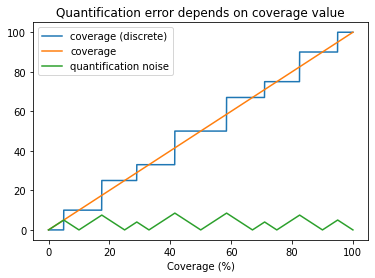

In [35]:
x = np.linspace(0,100,2001)
bins_borders = np.array([5,17.5,29,41.5,58.5,71,82.5,95,101])
bins_centers = np.array([0,10,25,33,50,67,75,90,100])
y_classes = np.digitize(x, bins_borders)
y_quant = bins_centers[y_classes[:,None]].squeeze()
error = np.abs(x-y_quant)

plt.title("Quantification error depends on coverage value")
plt.plot(x, y_quant, label="coverage (discrete)")
plt.plot(x, x, label = "coverage")
plt.plot(x, error, label = "quantification noise")
plt.xlabel("Coverage (%)")
plt.legend()

plt.show()

In [36]:
# Sanity check of borders and centers
list(map(lambda x: abs(x[0] - x[1]), zip(bins_borders[:-1],bins_centers[:-1]))) == list(map(lambda x: abs(x[0] - x[1]), zip(bins_borders,bins_centers[1:])))

True

Calculation of quantification noise expected value, under uniform coverage distribution assumptions

In [37]:
error.mean().round(2)

3.39

Calculation of quantification noise expected value, under plots coverage distribution

In [38]:
errors_by_class = np.zeros(shape=(9,))
for i in range(9):
    errors_by_class[i] = error[y_classes==i].mean()
errors_by_class = errors_by_class.round(2)
errors_by_class_mapper = {val_quant:mean_error for val_quant,mean_error in zip(bins_centers, errors_by_class)}
# See values:
l = list(zip(bins_centers, len(bins_centers)*["->"],errors_by_class, len(bins_centers)*["%pts"]))
l

[(0, '->', 2.48, '%pts'),
 (10, '->', 3.24, '%pts'),
 (25, '->', 3.15, '%pts'),
 (33, '->', 3.52, '%pts'),
 (50, '->', 4.25, '%pts'),
 (67, '->', 3.54, '%pts'),
 (75, '->', 3.13, '%pts'),
 (90, '->', 3.25, '%pts'),
 (100, '->', 2.5, '%pts')]

Actual expected error of oracle by vegetation strata

In [40]:
df_errors = df.copy()
df_errors[["vt_veg_b","vt_veg_moy","vt_veg_h"]] = df_errors[["vt_veg_b","vt_veg_moy","vt_veg_h"]].replace(errors_by_class_mapper)
print(f"Actual error due to quantization: {df_errors[['vt_veg_b','vt_veg_moy','vt_veg_h']].values.mean()}")
df_errors[["vt_veg_b","vt_veg_moy","vt_veg_h"]].describe().loc["mean"]

Actual error due to quantization: 3.070735042735043


vt_veg_b      3.143077
vt_veg_moy    3.047179
vt_veg_h      3.021949
Name: mean, dtype: float64

Calculation of adapted MAE, relative to class to predict

In [ ]:
# # mae2
# df_mae2 = df.copy()
# bb = [0] + bins_borders.tolist()
# center_to_border_dict = {center: borders for center, borders in zip(bins_centers, zip(bb[:-1], bb[1:]))}
# center_to_border_dict
# def compute_mae2(pred, vt):
#     borders = center_to_border_dict[vt]
#     if borders[0] <= pred <= borders[1]:
#         return 0.0
#     else:
#         return min( abs(borders[0]-pred), abs(borders[1]-pred))
    
# # apply to df
# mae2_b = df_mae2.apply(lambda x: compute_mae2(x.pred_veg_b, x.vt_veg_b), axis=1).mean().round(2)
# mae2_moy = df_mae2.apply(lambda x: compute_mae2(x.pred_veg_moy, x.vt_veg_moy), axis=1).mean().round(2)
# mae2_h = df_mae2.apply(lambda x: compute_mae2(x.pred_veg_h, x.vt_veg_h), axis=1).mean().round(2)
# mae2_b, mae2_moy, mae2_h

In [11]:
# get average width of class for each class
def compute_width(vt):
    borders = center_to_border_dict[vt]
    return abs(borders[0] -borders[1])  
# apply to df
width_b = df_mae2.apply(lambda x: compute_width(x.vt_veg_b), axis=1).mean().round(2)
width_moy = df_mae2.apply(lambda x: compute_width(x.vt_veg_moy), axis=1).mean().round(2)
width_h = df_mae2.apply(lambda x: compute_width(x.vt_veg_h), axis=1).mean().round(2)
width_b, width_moy, width_h

(10.75, 9.89, 9.83)

## 2. Calculation of induced error under the hypothesis of a normally distributed, small error made by the agent. 

### 2.A Evaluation using MAE

Situation:
- Observations have an inherent measurement error, which follows a gaussian variable of zero mean.
- This can impacts ground-truths with threshold effects when measurement is ouside GT class, due to quantification.
- This time, quantification error amplifies measurement error.
- A perfect predictive model would make a symmetrical prediction error relative to ground truths.
- Different assumptions of stdev of measurement error are compared.
Conclusion:
- Even conservative stdev hypotheses lead to high MAE.
- We have to compare with MAE2.

We first define different gaussian distributions that represent the measurement error. We visualize it and study probabilities of being lower than given absolute errors.

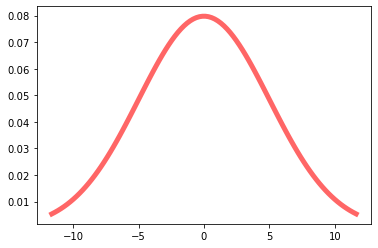

In [45]:
from scipy.stats import norm

stdev_of_error = 5  # in percentage of coverage ; 95.4% of values will be in [-2*sigma, +2*sigma]
imprecision_generator = norm(0, stdev_of_error)
fig, ax = plt.subplots(1, 1)
x = np.linspace(imprecision_generator.ppf(0.01),
                imprecision_generator.ppf(0.99), 100)
ax.plot(x, imprecision_generator.pdf(x),
       'r-', lw=5, alpha=0.6, label='norm pdf')
plt.show()

In [77]:
stdev_of_error_list = [5, 10, 15, 20]
above_error_list = [2.5, 5, 7.5, 10, 12.5, 15, 20, 25, 30]

errors = np.empty((len(above_error_list), len(stdev_of_error_list)))

for idx_stdev, stdev_of_error in enumerate(stdev_of_error_list):
    imprecision_generator = norm(0, stdev_of_error)
    for idx_above_error, above_error in enumerate(above_error_list):
        prob = imprecision_generator.cdf(above_error) - imprecision_generator.cdf(-above_error)
        errors[idx_above_error, idx_stdev] = prob

df_errors = pd.DataFrame(
    data=errors,
    index=[f"|e|<{s}" for s in above_error_list],
    columns=[f"stdev={s}" for s in stdev_of_error_list],
).round(2)
df_errors

,stdev=5,stdev=10,stdev=15,stdev=20
|e|<2.5,0.38,0.20,0.13,0.10
|e|<5,0.68,0.38,0.26,0.20
|e|<7.5,0.87,0.55,0.38,0.29
|e|<10,0.95,0.68,0.50,0.38
|e|<12.5,0.99,0.79,0.60,0.47
|e|<15,1.00,0.87,0.68,0.55
|e|<20,1.00,0.95,0.82,0.68
|e|<25,1.00,0.99,0.90,0.79
|e|<30,1.00,1.00,0.95,0.87


In [83]:
print(f"Deltas d for p(e>p) for proba \np = {[0.01,0.05,0.25,0.5,0.75,0.95,0.99]} are\nd = {[np.round(imprecision_generator.ppf(f),1) for f in [0.01,0.05,0.25,0.5,0.75,0.95,0.99]]}")
print(f"proba of an error above 20% is {imprecision_generator.cdf(-20) * 2:.2f}")
stdev_of_error=10
bins_borders = np.array([5,17.5,29,41.5,58.5,71,82.5,95,101])
bins_centers = np.array([0,10,25,33,50,67,75,90,100])
bb = [0] + bins_borders.tolist()
center_to_border_dict = {center: borders for center, borders in zip(bins_centers, zip(bb[:-1], bb[1:]))}
imprecision_generator = norm(0, stdev_of_error)
expected_E = []
for center, (lower_b, upper_b) in center_to_border_dict.items():
    E_list = []
    for coverage in np.arange(lower_b,upper_b + 0.1, 0.25):  # we always include both border in this range
        E = 0.0
        W = 0.0
        for imprecision_delta in np.arange(-33,33, 0.25):
            w = imprecision_generator.pdf(imprecision_delta)
            coverage_with_imprecision = coverage + imprecision_delta
            # we accept that 0% and 100% are more likely errors when close to them
            coverage_with_imprecision = max(coverage_with_imprecision, 0)
            coverage_with_imprecision = min(coverage_with_imprecision, 100)
            if lower_b <= coverage_with_imprecision <= upper_b:
                E = E + w * abs(coverage - center)  # quantification noise N°1
            else:
                closest_center = bins_centers[np.argsort(abs(bins_centers - coverage_with_imprecision))[1]]
                E = E + w * abs(coverage -  closest_center)  # quantification noise N°2
            W = W + w  # accumularte weights as well
        E_list.append(E / W)
    expected_E_in_class = np.mean(E_list)
    
    print(f"e={expected_E_in_class:.2}% for range [{lower_b};{upper_b}]")
    expected_E.append(expected_E_in_class)
print(f"Expected error with evaluation error of stdev={stdev_of_error} is {np.mean(expected_E).round(2)}")

Deltas d for p(e>p) for proba 
p = [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 0.99] are
d = [-11.6, -8.2, -3.4, 0.0, 3.4, 8.2, 11.6]
proba of an error above 20% is 0.00
e=5.2% for range [0;5.0]
e=5.7% for range [5.0;17.5]
e=6.9% for range [17.5;29.0]
e=7.2% for range [29.0;41.5]
e=8.4% for range [41.5;58.5]
e=7.2% for range [58.5;71.0]
e=6.9% for range [71.0;82.5]
e=5.8% for range [82.5;95.0]
e=4.9% for range [95.0;101.0]
Expected error with evaluation error of stdev=10 is 6.46


### 2.B Evaluation using MAE2

Situation:
- Observations have an inherent measurement error, which follows a gaussian variable of zero mean.
- This can impacts ground-truths with threshold effects when measurement is ouside GT class, due to quantification.
- This time, quantification error amplifies measurement error.
- Different assumptions of stdev of measurement error are compared.

Conclusion:
- Using MAE2 gives a more robust estimation of what on can achieve in terms of performance


N.B. analyses are now produced in quantification_error.py